In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate
import pickle

In [2]:
# Load dataset
csv_path = "E:\Github\Sentiment-Analysis-Speech-Emotion-Recognition\Dataset\dataset.csv"
df = pd.read_csv(csv_path)

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2449 entries, 0 to 2448
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence    2449 non-null   object
 1   Type        2449 non-null   object
 2   Factuality  2449 non-null   object
 3   Sentiment   2449 non-null   object
dtypes: object(4)
memory usage: 76.7+ KB
None

First 5 Rows:
                              Sentence         Type  Factuality  Sentiment
0                     The sky is blue.  Affirmation     Factual    Neutral
1                   I love sunny days!  Affirmation  Subjective  Happiness
2            This pizza is disgusting.  Affirmation  Subjective      Anger
3  Water boils at 100 degrees Celsius.  Affirmation     Factual    Neutral
4   I don't think this is a good idea.     Negation  Subjective    Sadness


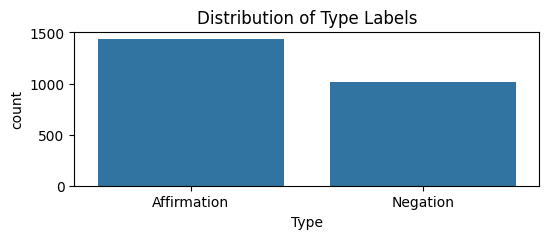

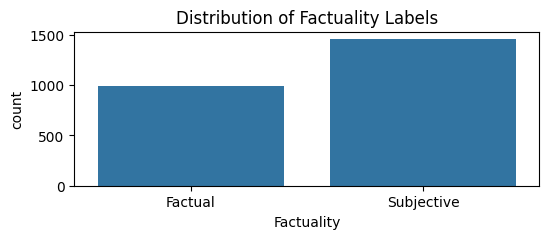

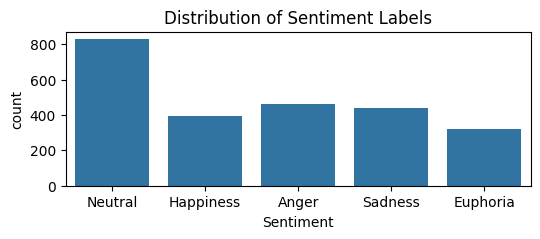

In [3]:
# Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

plt.figure(figsize=(6, 2))
sns.countplot(data=df, x="Type")
plt.title("Distribution of Type Labels")
plt.show()

plt.figure(figsize=(6, 2))
sns.countplot(data=df, x="Factuality")
plt.title("Distribution of Factuality Labels")
plt.show()

plt.figure(figsize=(6, 2))
sns.countplot(data=df, x="Sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()

In [4]:
# Initialize sentence embedding model
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = embedding_model.encode(df["Sentence"].tolist())

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Fit on a large corpus
vectorizer = TfidfVectorizer(max_features=5000)
corpus = df["Sentence"].tolist()
vectorizer.fit(corpus)

# Step 2: Fix the vocabulary
fixed_vocab = vectorizer.get_feature_names_out()
vectorizer_fixed = TfidfVectorizer(vocabulary=fixed_vocab)

# Fit and transform the corpus using the fixed vocabulary
vectorizer_fixed.fit(corpus)  # This ensures the vectorizer is "fitted"
X_tfidf = vectorizer_fixed.transform(corpus)

print(X_tfidf.shape)  # (num_samples, 5000)

# Save the vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer_fixed, f)


(2449, 2754)


In [6]:
# Label encoding
type_mapping = {"Affirmation": 0, "Negation": 1}
fact_subj_mapping = {"Factual": 0, "Subjective": 1}
sentiment_mapping = {"Sadness": 0, "Anger": 1, "Neutral": 2, "Happiness": 3, "Euphoria": 4}

df["Type"] = df["Type"].map(type_mapping).fillna(-1).astype(int)
df["Factuality"] = df["Factuality"].map(fact_subj_mapping).fillna(-1).astype(int)
df["Sentiment"] = df["Sentiment"].map(sentiment_mapping).fillna(-1).astype(int)

# Convert labels to NumPy arrays
type_labels = df["Type"].values
fact_subj_labels = df["Factuality"].values
sentiment_labels = df["Sentiment"].values

In [7]:
# Train-Test Split
def split_data(X):
    return train_test_split(X, type_labels, fact_subj_labels, sentiment_labels, test_size=0.2, random_state=42, stratify=sentiment_labels)

X_train_emb, X_test_emb, y_type_train, y_type_test, y_fact_train, y_fact_test, y_sent_train, y_sent_test = split_data(embeddings)
X_train_tfidf, X_test_tfidf, _, _, _, _, _, _ = split_data(X_tfidf)

In [8]:
# Hyperparameter Grids
logistic_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

xgb_param_grid = {
    "n_estimators": [200, 500, 1000, 1500], 
    "max_depth": [3, 5, 7, 9, 12],  
    "learning_rate": [0.01, 0.05, 0.1, 0.3],  
    "min_child_weight": [1, 3, 5, 7],  
    "subsample": [0.6, 0.8, 1.0],  
    "colsample_bytree": [0.6, 0.8, 1.0]  
}

# xgb_param_grid = {"n_estimators": [100], "max_depth": [3], "learning_rate": [0.1]}

In [9]:
# # Training Functions
# def train_model(model, param_grid, X_train, y_train, X_test, y_test, name):
#     grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     print(f"Best Model for {name}: {grid_search.best_params_}")
#     print(f"Accuracy for {name}: {acc:.4f}\n")
#     return best_model, acc

In [10]:
# Training Functions
def train_model(model, param_distributions, X_train, y_train, X_test, y_test, name, n_iter=100):
    random_search = RandomizedSearchCV(model, param_distributions, n_iter=n_iter, cv=3, scoring="accuracy", n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Best Model for {name}: {random_search.best_params_}")
    print(f"Accuracy for {name}: {acc:.4f}\n")
    return best_model, acc

In [11]:
# Store results
results = []

# Store the best models
best_models = {}

# Run all combinations and store results
for feature_name, (X_train, X_test) in zip(["Embedding", "TF-IDF"], [(X_train_emb, X_test_emb), (X_train_tfidf, X_test_tfidf)]):
    for model_name, (model, param_grid) in zip(["XGBoost", "Logistic Regression"], [(XGBClassifier(eval_metric="mlogloss"), xgb_param_grid), (LogisticRegression(max_iter=1000), logistic_param_grid)]):
        for task_name, (y_train, y_test) in zip(["Type", "Factuality", "Sentiment"], [(y_type_train, y_type_test), (y_fact_train, y_fact_test), (y_sent_train, y_sent_test)]):
            # Train the model
            trained_model, acc = train_model(model, param_grid, X_train, y_train, X_test, y_test, f"{task_name} ({feature_name} + {model_name})")
            
            # Predict with the trained model
            y_pred = trained_model.predict(X_test)
            
            # Calculate metrics
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Store result in the results list
            results.append((feature_name, model_name, task_name, acc, precision, recall, f1, conf_matrix))
            
            # Check if this model is the best for the current task based on accuracy
            if task_name not in best_models or acc > best_models[task_name]["accuracy"]:
                best_models[task_name] = {
                    "feature_name": feature_name,
                    "model_name": model_name,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1,
                    "conf_matrix": conf_matrix,
                    "trained_model": trained_model
                }

Best Model for Type (Embedding + XGBoost): {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy for Type (Embedding + XGBoost): 0.9408

Best Model for Factuality (Embedding + XGBoost): {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy for Factuality (Embedding + XGBoost): 0.9490

Best Model for Sentiment (Embedding + XGBoost): {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy for Sentiment (Embedding + XGBoost): 0.8878



e:\miniconda3\envs\MIAA\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Model for Type (Embedding + Logistic Regression): {'C': 10}
Accuracy for Type (Embedding + Logistic Regression): 0.9490



e:\miniconda3\envs\MIAA\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Model for Factuality (Embedding + Logistic Regression): {'C': 100}
Accuracy for Factuality (Embedding + Logistic Regression): 0.9388



e:\miniconda3\envs\MIAA\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Model for Sentiment (Embedding + Logistic Regression): {'C': 10}
Accuracy for Sentiment (Embedding + Logistic Regression): 0.8816

Best Model for Type (TF-IDF + XGBoost): {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy for Type (TF-IDF + XGBoost): 0.9327

Best Model for Factuality (TF-IDF + XGBoost): {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy for Factuality (TF-IDF + XGBoost): 0.8959

Best Model for Sentiment (TF-IDF + XGBoost): {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy for Sentiment (TF-IDF + XGBoost): 0.7918

Best Model for Type (TF-IDF + Logistic Regression): {'C': 100}
Accuracy for Type (TF-IDF + Logistic Regression): 0.9469

Best Model for Factuality (TF-IDF + Logistic Regression): {'C': 100}
Accuracy for

e:\miniconda3\envs\MIAA\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\miniconda3\envs\MIAA\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\miniconda3\envs\MIAA\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Model for Sentiment (TF-IDF + Logistic Regression): {'C': 10}
Accuracy for Sentiment (TF-IDF + Logistic Regression): 0.8469



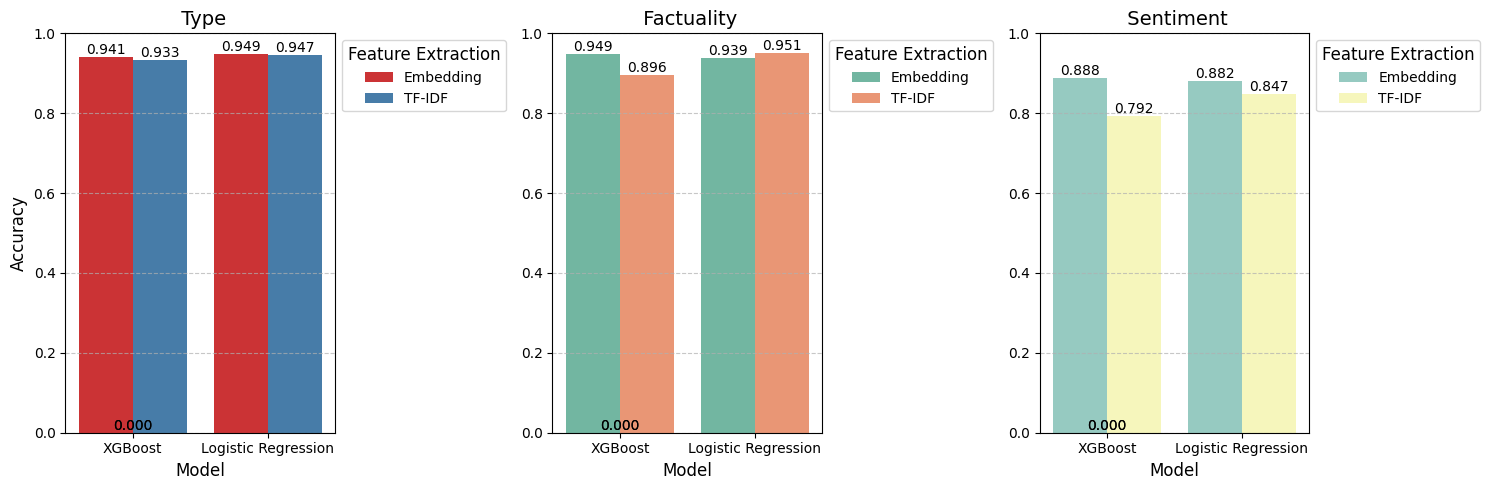

In [12]:
# Convert results to DataFrame with 8 columns (including confusion matrix)
results_df = pd.DataFrame(results, columns=["Feature", "Model", "Task", "Accuracy", "Precision", "Recall", "F1", "ConfMatrix"])

tasks = ["Type", "Factuality", "Sentiment"]
colors = ["Set1", "Set2", "Set3"]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(tasks), figsize=(15, 5))

for i, task in enumerate(tasks):
    task_df = results_df[results_df["Task"] == task]
    ax = axes[i]
    
    # Create the barplot
    barplot = sns.barplot(
        data=task_df, 
        x="Model", 
        y="Accuracy", 
        hue="Feature", 
        dodge=True, 
        palette=colors[i], 
        ax=ax
    )
    
    # Add value labels on top of bars
    for p in barplot.patches:
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')
    
    # Set title and axis labels
    ax.set_title(f" {task}", fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Model", fontsize=12)
    if i == 0:
        ax.set_ylabel("Accuracy", fontsize=12)
    else:
        ax.set_ylabel("")
    
    # Add gridlines
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Customize legend
    ax.legend(title="Feature Extraction", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    
# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()





         Best model for Type          

╒═══════════╤═════════════════════╕
│ Metric    │ Value               │
╞═══════════╪═════════════════════╡
│ Feature   │ Embedding           │
├───────────┼─────────────────────┤
│ Model     │ Logistic Regression │
├───────────┼─────────────────────┤
│ Accuracy  │ 0.9490              │
├───────────┼─────────────────────┤
│ Precision │ 0.9490              │
├───────────┼─────────────────────┤
│ Recall    │ 0.9490              │
├───────────┼─────────────────────┤
│ F1 Score  │ 0.9489              │
╘═══════════╧═════════════════════╛


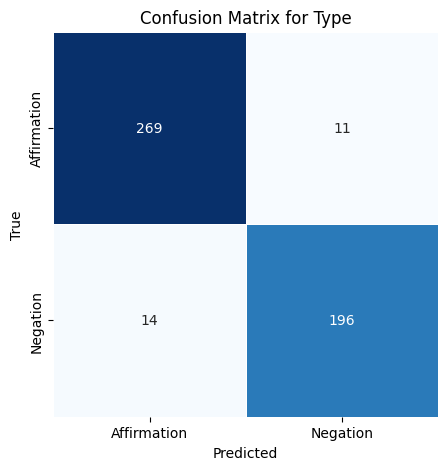




      Best model for Factuality       

╒═══════════╤═════════════════════╕
│ Metric    │ Value               │
╞═══════════╪═════════════════════╡
│ Feature   │ TF-IDF              │
├───────────┼─────────────────────┤
│ Model     │ Logistic Regression │
├───────────┼─────────────────────┤
│ Accuracy  │ 0.9510              │
├───────────┼─────────────────────┤
│ Precision │ 0.9511              │
├───────────┼─────────────────────┤
│ Recall    │ 0.9510              │
├───────────┼─────────────────────┤
│ F1 Score  │ 0.9511              │
╘═══════════╧═════════════════════╛


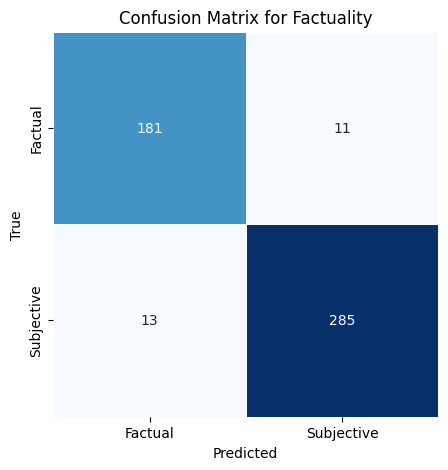




       Best model for Sentiment       

╒═══════════╤═══════════╕
│ Metric    │ Value     │
╞═══════════╪═══════════╡
│ Feature   │ Embedding │
├───────────┼───────────┤
│ Model     │ XGBoost   │
├───────────┼───────────┤
│ Accuracy  │ 0.8878    │
├───────────┼───────────┤
│ Precision │ 0.8897    │
├───────────┼───────────┤
│ Recall    │ 0.8878    │
├───────────┼───────────┤
│ F1 Score  │ 0.8879    │
╘═══════════╧═══════════╛


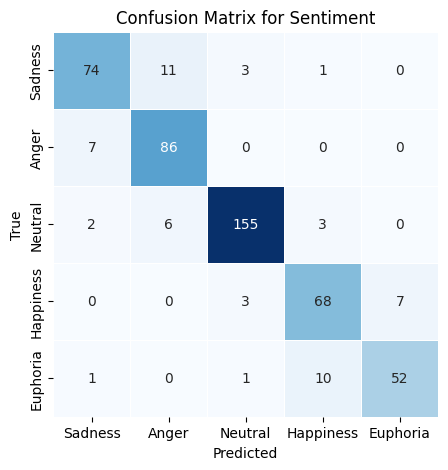

In [13]:

# Print the summary of the best models and display confusion matrix heatmap
for task_name, model_info in best_models.items():
    print(f"\n{'='*40}")
    print(f"{'Best model for ' + task_name:^38}")
    print(f"{'='*40}\n")
    
    # Prepare the table for a clean display
    table = [
        ["Feature", model_info['feature_name']],
        ["Model", model_info['model_name']],
        ["Accuracy", f"{model_info['accuracy']:.4f}"],
        ["Precision", f"{model_info['precision']:.4f}"],
        ["Recall", f"{model_info['recall']:.4f}"],
        ["F1 Score", f"{model_info['f1']:.4f}"],
    ]
    
    # Display the table neatly
    print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))
    
    # Plot the confusion matrix using a heatmap
    conf_matrix = model_info['conf_matrix']
    
    # Determine the labels based on the task_name
    if task_name == "Type":
        labels = list(type_mapping.keys())
    elif task_name == "Factuality":
        labels = list(fact_subj_mapping.keys())
    elif task_name == "Sentiment":
        labels = list(sentiment_mapping.keys())
    else:
        # Default to numeric labels if no mapping is found
        labels = list(range(conf_matrix.shape[0]))  # Use the number of classes in the confusion matrix
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    
    plt.title(f"Confusion Matrix for {task_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(f"\n{'='*40}\n")


In [14]:
# Pickle the best models
for task_name, model_info in best_models.items():
    model_filename = f"best_model_{task_name}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model_info["trained_model"], f)
    print(f"Best model for {task_name} saved as {model_filename}")

Best model for Type saved as best_model_Type.pkl
Best model for Factuality saved as best_model_Factuality.pkl
Best model for Sentiment saved as best_model_Sentiment.pkl
